<a href="https://colab.research.google.com/github/tithihalder9/TithiHalder23-ML_Lab_Code/blob/main/Q10_Pima_indians_diabetes_data_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset
data = fetch_openml(name="diabetes", version=1, as_frame=True)
df = data.frame

# Rename target to 'Outcome'
df.rename(columns={"class": "Outcome"}, inplace=True)

# Save as CSV file
df.to_csv("pima-indians-diabetes.data.csv", index=False)

print("✅ Dataset created: pima-indians-diabetes.data.csv")
print("Shape:", df.shape)
print(df.head())


✅ Dataset created: pima-indians-diabetes.data.csv
Shape: (768, 9)
   preg  plas  pres  skin  insu  mass   pedi  age          Outcome
0     6   148    72    35     0  33.6  0.627   50  tested_positive
1     1    85    66    29     0  26.6  0.351   31  tested_negative
2     8   183    64     0     0  23.3  0.672   32  tested_positive
3     1    89    66    23    94  28.1  0.167   21  tested_negative
4     0   137    40    35   168  43.1  2.288   33  tested_positive


Column 'Outcome' contains non-numeric values: ['tested_positive' 'tested_negative']

=== SVM (RBF Kernel) ===
Accuracy: 0.7273
Recall: 0.5636
Precision: 0.6327
F1-Score: 0.5962
Confusion Matrix:
 [[81 18]
 [24 31]]

=== Naive Bayes ===
Accuracy: 0.7662
Recall: 0.7091
Precision: 0.6610
F1-Score: 0.6842
Confusion Matrix:
 [[79 20]
 [16 39]]

=== Decision Tree ===
Accuracy: 0.7468
Recall: 0.7273
Precision: 0.6250
F1-Score: 0.6723
Confusion Matrix:
 [[75 24]
 [15 40]]

=== KNN ===
Accuracy: 0.6883
Recall: 0.4909
Precision: 0.5745
F1-Score: 0.5294
Confusion Matrix:
 [[79 20]
 [28 27]]


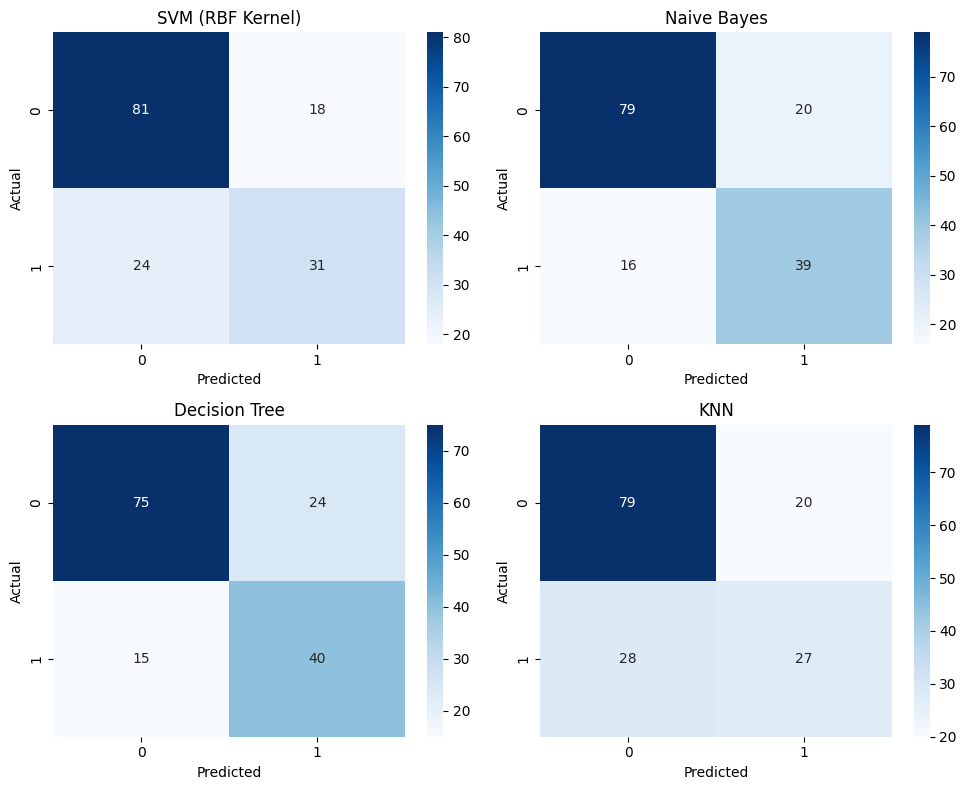

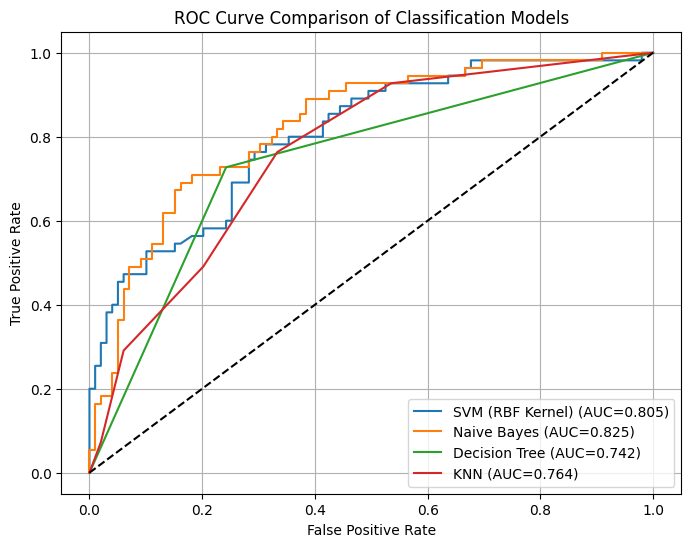

In [5]:
# Compare SVM, Naive Bayes, Decision Tree, KNN
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("pima-indians-diabetes.data.csv")

# Check for non-numeric values before conversion
for col in df.columns:
    non_numeric_values = df[pd.to_numeric(df[col], errors='coerce').isna()][col].unique()
    if len(non_numeric_values) > 0:
        print(f"Column '{col}' contains non-numeric values: {non_numeric_values}")

# If dataset columns are strings (object), convert to numeric, except for 'Outcome'
for col in df.columns:
    if col != 'Outcome':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values (this will now only drop based on numeric columns)
df = df.dropna()

# Encode the 'Outcome' column
le = LabelEncoder()
df['Outcome'] = le.fit_transform(df['Outcome'])


# Split features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define models
models = {
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Handle cases where predict_proba might not be available or has only one class
    if hasattr(model, 'predict_proba') and model.predict_proba(X_test).shape[1] > 1:
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba or with a single class, use decision_function or assign a default
        if hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = np.zeros_like(y_pred, dtype=float) # Default to 0 probability


    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Ensure y_test and y_prob have the same number of samples for roc_curve
    if len(y_test) > 0 and len(y_prob) == len(y_test):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, roc_auc = None, None, None # Handle cases with no data or mismatch


    results[name] = {
        'accuracy': acc, 'recall': rec, 'precision': prec, 'f1_score': f1,
        'confusion_matrix': cm, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc
    }

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

# --- Heatmap Confusion Matrices ---
plt.figure(figsize=(10, 8))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# --- ROC Curve Comparison ---
plt.figure(figsize=(8,6))
for name, res in results.items():
    if res['fpr'] is not None and res['tpr'] is not None and res['roc_auc'] is not None:
        plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC={res['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison of Classification Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()